In [39]:
import re
true_features = []
with open('Feature_ranking', 'r', encoding="utf-8") as file:
    features = file.read()
    for line in features.split('\n'):
        if line.endswith('True'):
            true_features.append(re.findall(r"'([^']*)'", line)[0])

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

data1 = pd.read_csv('x_matricer/x_matrix_pre_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns=['IDno','dead30','dead90','dead365'])
data2 = pd.read_csv('x_matricer/x_matrix_phase_1_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')
data3 = pd.read_csv('x_matricer/x_matrix_phase_2_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')
data4 = pd.read_csv('x_matricer/x_matrix_phase_3_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')
data5 = pd.read_csv('x_matricer/x_matrix_phase_4_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')
data6 = pd.read_csv('x_matricer/x_matrix_phase_5_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')
y_pred = pd.read_csv('y_pred_4729.csv').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')

base = data1
phase1 = pd.concat([data1, data2], axis = 1)
phase2 = pd.concat([data1, data2, data3], axis = 1)
phase3 = pd.concat([data1, data2, data3, data4], axis = 1)
phase4 = pd.concat([data1, data2, data3, data4, data5], axis = 1)
phase5 = pd.concat([data1, data2, data3, data4, data5, data6], axis = 1)

data_list = [base, phase1, phase2, phase3, phase4, phase5]
preds_log = []
models_log = []
holdout_log = []
true_log = []
for i in range(len(data_list)):
    data = data_list[i]
    # data = data[data.columns.intersection(true_features)]
    np.random.seed(42)

    # Convert to numpy array and generate synthetic labels for demonstration
    X = data.to_numpy()
    y = y_pred.to_numpy()
    # Standardize the data
    X = StandardScaler().fit_transform(X)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).flatten()

    # Create a dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Split data into holdout set and remaining set
    train_indices, holdout_indices = train_test_split(np.arange(len(dataset)), test_size=500, random_state=42, stratify=y_tensor.numpy())

    holdout_set = Subset(dataset, holdout_indices)
    remaining_set = Subset(dataset, train_indices)

    y_1_percent = np.count_nonzero(y_tensor) / len(y_tensor)
    y_0_percent = 1 - y_1_percent
    print(f"Class 1 percentage: {y_1_percent * 100:.2f}%")
    print(f"Class 0 percentage: {y_0_percent * 100:.2f}%")
    # Define class weights for BCEWithLogitsLoss
    class_weights = torch.tensor([1/y_0_percent, 1/y_1_percent])

    # Define the logistic regression model with L2 regularization
    class LogisticRegressionModel(nn.Module):
        def __init__(self, input_dim):
            super(LogisticRegressionModel, self).__init__()
            self.linear = nn.Linear(input_dim, 1)
        
        def forward(self, x):
            out = torch.sigmoid(self.linear(x))
            return out

    input_dim = data.shape[1]

    # Function to get target tensor from Subset
    def get_targets(subset):
        return subset.dataset.tensors[1][subset.indices]

    # Get target tensors for holdout and remaining sets
    holdout_targets = get_targets(holdout_set)
    remaining_targets = get_targets(remaining_set)

    # Print class distributions
    print(f"Class distribution in holdout set: {np.unique(holdout_targets.numpy(), return_counts=True)}")
    print(f"Class distribution in remaining set: {np.unique(remaining_targets.numpy(), return_counts=True)}")

    weight_decay_values = np.logspace(-5, 1, 7)  # for example, try values from 1e-5 to 10

    # Function to train and evaluate the model with L2 regularization
    def train_and_evaluate_model(train_loader, val_loader, input_dim, num_epochs=10, lr=0.01, weight_decay=1e-5):
        model = LogisticRegressionModel(input_dim)
        criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Training loop
        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Evaluate on validation set
        model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                predicted = (outputs > 0.5).float().squeeze()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        f1 = f1_score(all_labels, all_preds)
        accuracy = correct / total
        return f1, model, accuracy, all_preds, all_labels

    outer_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Function to perform grid search over weight_decay values
    def grid_search(train_set, outer_kf, weight_decays, input_dim, num_epochs=10, lr=0.01):
        best_weight_decay = None
        best_outer_f1 = 0
        y_remaining = y_tensor[train_indices].numpy()

        for weight_decay in weight_decays:
            outer_f1_scores = []
            
            for outer_train_index, outer_test_index in outer_kf.split(np.zeros(len(train_set)), y_remaining):
                
                outer_train_subset = Subset(train_set, outer_train_index)
                outer_test_subset = Subset(train_set, outer_test_index)
                
                # Inner 5-Fold Cross-Validation
                inner_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                inner_f1_scores = []
                
                for inner_train_index, inner_val_index in inner_kf.split(np.zeros(len(outer_train_index)), y_remaining[outer_train_index]):
                    
                    inner_train_indices = np.array(outer_train_index)[inner_train_index]
                    inner_val_indices = np.array(outer_train_index)[inner_val_index]
                    
                    inner_train_subset = Subset(train_set, inner_train_indices)
                    inner_val_subset = Subset(train_set, inner_val_indices)
                    
                    train_loader = DataLoader(inner_train_subset, batch_size=64, shuffle=True)
                    val_loader = DataLoader(inner_val_subset, batch_size=64, shuffle=False)
                    
                    f1, _, _, _, _ = train_and_evaluate_model(train_loader, val_loader, input_dim, num_epochs, lr, weight_decay)
                    inner_f1_scores.append(f1)
                            
                # Train on outer train subset and evaluate on outer test subset
                train_loader = DataLoader(outer_train_subset, batch_size=64, shuffle=True)
                test_loader = DataLoader(outer_test_subset, batch_size=64, shuffle=False)
                
                outer_f1, _, _, _, _ = train_and_evaluate_model(train_loader, test_loader, input_dim, num_epochs, lr, weight_decay)
                outer_f1_scores.append(outer_f1)
            
            mean_outer_f1 = np.mean(outer_f1_scores)
            print(f'Weight Decay: {weight_decay}, Mean Outer F1 Score: {mean_outer_f1:.4f}')
            
            if mean_outer_f1 > best_outer_f1:
                best_outer_f1 = mean_outer_f1
                best_weight_decay = weight_decay
        
        return best_weight_decay


    # Perform grid search over weight_decay values

    best_weight_decay = grid_search(remaining_set, outer_kf, weight_decay_values, input_dim, num_epochs=10, lr=0.01)

    print(f'Best Weight Decay: {best_weight_decay}')

    # Evaluate the final model on the holdout set
    final_model = LogisticRegressionModel(input_dim)
    train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
    holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

    # Train the final model with the best weight decay found
    holdout_f1, _, holdout_acc, holdout_pred, holdout_all_labels = train_and_evaluate_model(train_loader, holdout_loader, input_dim, num_epochs=10, lr=0.01, weight_decay=best_weight_decay)
    print(f'Final Model F1 Score on Holdout Set: {holdout_f1:.4f}')
    print(f'Holdout Set Accuracy: {holdout_acc * 100:.2f}%')
    torch.save(final_model.state_dict(), f"Variables_log_reg/phase {i}")
    models_log.append(final_model)
    holdout_log.append(holdout_loader)
    true_log.append(holdout_all_labels)
    preds_log.append(holdout_pred)

    # Evaluate precision and recall on holdout set
    final_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in holdout_loader:
            outputs = final_model(inputs)
            predicted = (outputs > 0.5).float()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    holdout_precision = precision_score(all_labels, all_preds)
    holdout_recall = recall_score(all_labels, all_preds)

    print(f'Holdout Set Precision: {holdout_precision * 100:.2f}%')
    print(f'Holdout Set Recall: {holdout_recall * 100:.2f}%')

    # Open the file in write mode
    with open('Variables_log_reg/results.txt', 'a') as file:
        print(f"Phase {i}", file=file)
        print(f'Best Weight Decay: {best_weight_decay}', file=file)
        print(f'Final Model F1 Score on Holdout Set: {holdout_f1:.4f}', file=file)
        print(f'Holdout Set Accuracy: {holdout_acc * 100:.2f}%', file=file)
        print(f'Holdout Set Precision: {holdout_precision * 100:.2f}%', file=file)
        print(f'Holdout Set Recall: {holdout_recall * 100:.2f}%', file=file)
        print('\n', file=file)
        print('Output written to output.txt')


Class 1 percentage: 2.56%
Class 0 percentage: 97.44%
Class distribution in holdout set: (array([0., 1.], dtype=float32), array([487,  13], dtype=int64))
Class distribution in remaining set: (array([0., 1.], dtype=float32), array([4121,  108], dtype=int64))
Weight Decay: 1e-05, Mean Outer F1 Score: 0.1157
Weight Decay: 0.0001, Mean Outer F1 Score: 0.1141
Weight Decay: 0.001, Mean Outer F1 Score: 0.1152
Weight Decay: 0.01, Mean Outer F1 Score: 0.1131
Weight Decay: 0.1, Mean Outer F1 Score: 0.1133
Weight Decay: 1.0, Mean Outer F1 Score: 0.0934
Weight Decay: 10.0, Mean Outer F1 Score: 0.0794
Best Weight Decay: 1e-05
Final Model F1 Score on Holdout Set: 0.1297
Holdout Set Accuracy: 67.80%
Holdout Set Precision: 3.19%
Holdout Set Recall: 69.23%
Output written to output.txt
Class 1 percentage: 2.56%
Class 0 percentage: 97.44%
Class distribution in holdout set: (array([0., 1.], dtype=float32), array([487,  13], dtype=int64))
Class distribution in remaining set: (array([0., 1.], dtype=float32),

In [48]:
import pickle
file_path = 'Variables_log_reg/preds_log.pickle'

# Open the file in binary mode
with open(file_path, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(preds_log, file)

In [ ]:
data1 = pd.read_csv('x_matricer/x_matrix_pre_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns=['IDno','dead30','dead90','dead365'])
data2 = pd.read_csv('x_matricer/x_matrix_phase_1_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')
data3 = pd.read_csv('x_matricer/x_matrix_phase_2_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')
data4 = pd.read_csv('x_matricer/x_matrix_phase_3_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')
data5 = pd.read_csv('x_matricer/x_matrix_phase_4_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')
data6 = pd.read_csv('x_matricer/x_matrix_phase_5_4729.csv', compression = 'gzip').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')
y_pred = pd.read_csv('y_pred_4729.csv').sort_values(by='IDno',ignore_index=True).drop(columns='IDno')

base = data1
phase1 = pd.concat([data1, data2], axis = 1)
phase2 = pd.concat([data1, data2, data3], axis = 1)
phase3 = pd.concat([data1, data2, data3, data4], axis = 1)
phase4 = pd.concat([data1, data2, data3, data4, data5], axis = 1)
phase5 = pd.concat([data1, data2, data3, data4, data5, data6], axis = 1)

data_list = [base, phase1, phase2, phase3, phase4, phase5]
preds_log = []
models_log = []
holdout_log = []
true_log = []
for i in range(len(data_list)):
    data = data_list[i]
    np.random.seed(42)

    # Convert to numpy array and generate synthetic labels for demonstration
    X = data.to_numpy()
    y = y_pred.to_numpy()
    # Standardize the data
    X = StandardScaler().fit_transform(X)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).flatten()

    # Create a dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Split data into holdout set and remaining set
    train_indices, holdout_indices = train_test_split(np.arange(len(dataset)), test_size=500, random_state=42, stratify=y_tensor.numpy())

    holdout_set = Subset(dataset, holdout_indices)
    remaining_set = Subset(dataset, train_indices)

    y_1_percent = np.count_nonzero(y_tensor) / len(y_tensor)
    y_0_percent = 1 - y_1_percent
    print(f"Class 1 percentage: {y_1_percent * 100:.2f}%")
    print(f"Class 0 percentage: {y_0_percent * 100:.2f}%")
    # Define class weights for BCEWithLogitsLoss
    class_weights = torch.tensor([1/y_0_percent, 1/y_1_percent])

    # Define the logistic regression model with L2 regularization
    class LogisticRegressionModel(nn.Module):
        def __init__(self, input_dim):
            super(LogisticRegressionModel, self).__init__()
            self.linear = nn.Linear(input_dim, 1)
        
        def forward(self, x):
            out = torch.sigmoid(self.linear(x))
            return out

    input_dim = data.shape[1]

    # Function to get target tensor from Subset
    def get_targets(subset):
        return subset.dataset.tensors[1][subset.indices]

    # Get target tensors for holdout and remaining sets
    holdout_targets = get_targets(holdout_set)
    remaining_targets = get_targets(remaining_set)    


# Evaluate the final model on the holdout set
    model = #mo
    train_loader = DataLoader(remaining_set, batch_size=64, shuffle=True)
    holdout_loader = DataLoader(holdout_set, batch_size=64, shuffle=False)

    # Train the final model with the best weight decay found
    holdout_f1, _, holdout_acc, holdout_pred, holdout_all_labels = train_and_evaluate_model(train_loader, holdout_loader, input_dim, num_epochs=10, lr=0.01, weight_decay=best_weight_decay)
    print(f'Final Model F1 Score on Holdout Set: {holdout_f1:.4f}')
    print(f'Holdout Set Accuracy: {holdout_acc * 100:.2f}%')
    models_log.append(final_model)
    holdout_log.append(holdout_loader)
    true_log.append(holdout_all_labels)
    preds_log.append(holdout_pred)

        # Evaluate precision and recall on holdout set
    final_model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in holdout_loader:
            outputs = final_model(inputs)
            predicted = (outputs > 0.5).float()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    holdout_precision = precision_score(all_labels, all_preds)
    holdout_recall = recall_score(all_labels, all_preds)

    print(f'Holdout Set Precision: {holdout_precision * 100:.2f}%')
    print(f'Holdout Set Recall: {holdout_recall * 100:.2f}%')

In [7]:
import re
true_features = []
with open('Feature_ranking', 'r') as file:
    features = file.read()
    for line in features.split('\n'):
        if line.endswith('True'):
            true_features.append(re.findall(r"'([^']*)'", line)[0])

In [55]:
from statsmodels.stats.contingency_tables import mcnemar
def compute_mcnemar_contingency(true_labels, pred_A, pred_B):
    assert len(true_labels) == len(pred_A) == len(pred_B), "Inputs must have the same length"
    
    n00 = 0  # Number of items misclassified by both A and B
    n01 = 0  # Number of items misclassified by A but not by B
    n10 = 0  # Number of items misclassified by B but not by A
    n11 = 0  # Number of items classified correctly by both A and B
    
    for true_label, pred_a, pred_b in zip(true_labels, pred_A, pred_B):
        if pred_a != true_label and pred_b != true_label:
            n00 += 1
        elif pred_a != true_label and pred_b == true_label:
            n01 += 1
        elif pred_a == true_label and pred_b != true_label:
            n10 += 1
        elif pred_a == true_label and pred_b == true_label:
            n11 += 1
    
    return n00, n01, n10, n11

from itertools import combinations
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar
from decimal import Decimal

names = ['pre', 'phase1', 'phase2', 'phase3', 'phase4', 'phase5']

# Initialize a dictionary to store p-values
p_value_table = {}

# Generate all combinations of pairs of indices
comparison_pairs = list(combinations(range(len(names)), 2))

for i, j in comparison_pairs:
    n00, n01, n10, n11 = compute_mcnemar_contingency(true_log[0], preds_log[i], preds_log[j])
    cont_table_pred_set = [[n00, n01], [n10, n11]]
    
    # Perform McNemar's test
    result = mcnemar(cont_table_pred_set)
    
    # Store p-value in the table for both (i, j) and (j, i)
    p_value_table.setdefault(names[i], {})[names[j]] = '%.2E' % Decimal(result.pvalue)
    p_value_table.setdefault(names[j], {})[names[i]] = '%.2E' % Decimal(result.pvalue)

# Convert the nested dictionary to a DataFrame
p_value_df = pd.DataFrame.from_dict(p_value_table, orient='index')

# Ensure rows and columns follow the order of names
p_value_df = p_value_df.reindex(index=names, columns=names)

print("P-Value Table:")
print(p_value_df)

P-Value Table:
             pre    phase1    phase2    phase3    phase4    phase5
pre          NaN  8.28E-01  5.30E-01  4.70E-01  4.48E-01  3.38E-01
phase1  8.28E-01       NaN  2.03E-01  2.54E-01  2.46E-01  1.89E-01
phase2  5.30E-01  2.03E-01       NaN  1.00E+00  9.15E-01  7.52E-01
phase3  4.70E-01  2.54E-01  1.00E+00       NaN  1.00E+00  8.01E-01
phase4  4.48E-01  2.46E-01  9.15E-01  1.00E+00       NaN  8.80E-01
phase5  3.38E-01  1.89E-01  7.52E-01  8.01E-01  8.80E-01       NaN


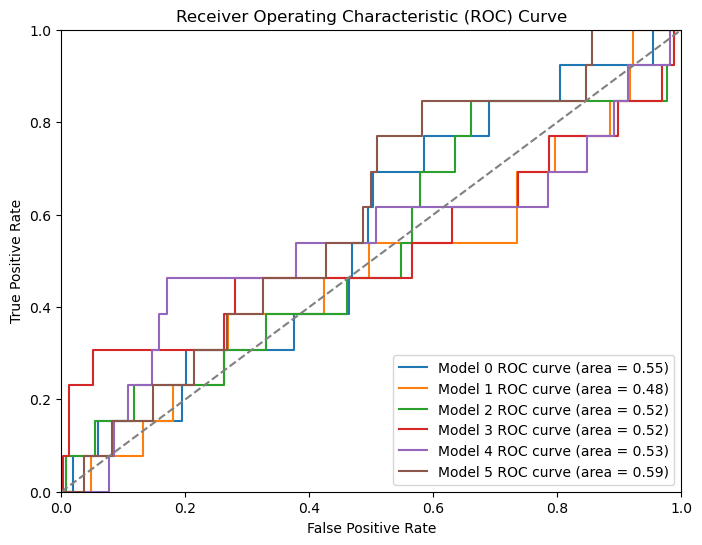

In [56]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_roc_auc(models, loaders):
    plt.figure(figsize=(8, 6))

    for i, (model, loader) in enumerate(zip(models, loaders)):
        model.eval()
        y_true = []
        y_scores = []

        with torch.no_grad():
            for images, labels in loader:
                outputs = model(images)
                y_true.extend(labels.numpy())
                y_scores.extend(outputs.numpy())

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        auc_score = roc_auc_score(y_true, y_scores)

        plt.plot(fpr, tpr, label=f'Model {i} ROC curve (area = {auc_score:.2f})')
    
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Example usage
# Assuming model0 and model1 are your models and holdout_loader0 and holdout_loader1 are the corresponding loaders
evaluate_roc_auc(models_log, holdout_log)

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Load your data and set up your variables as before...

data1 = pd.read_csv('x_matricer/x_matrix_pre_4729.csv', compression='gzip').sort_values(by='IDno', ignore_index=True).drop(columns=['IDno','dead30','dead90','dead365'])
data2 = pd.read_csv('x_matricer/x_matrix_phase_1_4729.csv', compression='gzip').sort_values(by='IDno', ignore_index=True).drop(columns='IDno')
data3 = pd.read_csv('x_matricer/x_matrix_phase_2_4729.csv', compression='gzip').sort_values(by='IDno', ignore_index=True).drop(columns='IDno')
data4 = pd.read_csv('x_matricer/x_matrix_phase_3_4729.csv', compression='gzip').sort_values(by='IDno', ignore_index=True).drop(columns='IDno')
data5 = pd.read_csv('x_matricer/x_matrix_phase_4_4729.csv', compression='gzip').sort_values(by='IDno', ignore_index=True).drop(columns='IDno')
data6 = pd.read_csv('x_matricer/x_matrix_phase_5_4729.csv', compression='gzip').sort_values(by='IDno', ignore_index=True).drop(columns='IDno')
y_pred = pd.read_csv('y_pred_4729.csv').sort_values(by='IDno', ignore_index=True).drop(columns='IDno')

base = data1
phase1 = pd.concat([data1, data2], axis=1)
phase2 = pd.concat([data1, data2, data3], axis=1)
phase3 = pd.concat([data1, data2, data3, data4], axis=1)
phase4 = pd.concat([data1, data2, data3, data4, data5], axis=1)
phase5 = pd.concat([data1, data2, data3, data4, data5, data6], axis=1)

data_list = [base, phase1, phase2, phase3, phase4, phase5]
# preds_log = []
# models_log = []
# holdout_log = []
# true_log = []

data = phase5
np.random.seed(42)

# Convert to numpy array and generate synthetic labels for demonstration
X = data.to_numpy()
y = y_pred.to_numpy().flatten()
# Standardize the data
X = StandardScaler().fit_transform(X)

# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
estimator = LogisticRegression(random_state=42)
rfecv = RFECV(estimator=estimator, step=5, cv=3, scoring='f1')
rfecv.fit(X, y)
    
# Get the selected features
selected_features = rfecv.support_
X_selected = X[:, selected_features]
    
# Print feature rankings
print(f"Phase 5 Feature Rankings:")
for rank, (feature, support) in enumerate(zip(data.columns, rfecv.support_), start=1):
    print(f"Rank {rank}: Feature '{feature}', Support: {support}")

c:\Users\NSCH0157\.conda\envs\Fagprojekt\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\NSCH0157\.conda\envs\Fagprojekt\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Phase 5 Feature Rankings:
Rank 1: Feature '107', Support: False
Rank 2: Feature '119', Support: False
Rank 3: Feature 'AAF', Support: False
Rank 4: Feature 'AMB', Support: False
Rank 5: Feature 'BFC', Support: False
Rank 6: Feature 'BFF', Support: False
Rank 7: Feature 'BOH', Support: False
Rank 8: Feature 'BVA', Support: False
Rank 9: Feature 'KCK', Support: False
Rank 10: Feature 'KFA_x', Support: False
Rank 11: Feature 'KFB_x', Support: False
Rank 12: Feature 'KFC_x', Support: False
Rank 13: Feature 'KFD_x', Support: False
Rank 14: Feature 'KFE_x', Support: False
Rank 15: Feature 'KFF_x', Support: False
Rank 16: Feature 'KFG_x', Support: False
Rank 17: Feature 'KFH_x', Support: False
Rank 18: Feature 'KFJ_x', Support: True
Rank 19: Feature 'KFK_x', Support: False
Rank 20: Feature 'KFL_x', Support: False
Rank 21: Feature 'KFM_x', Support: False
Rank 22: Feature 'KFN_x', Support: False
Rank 23: Feature 'KFP_x', Support: False
Rank 24: Feature 'KFQ_x', Support: False
Rank 25: Feature '